## Create and test ion channel model

In [1]:
from experiments.iha_markov import (sartiani_iv,
                                    sartiani_act)

In [2]:
from ionchannelABC.experiment import setup

In [3]:
modelfile = 'models/iha_markov.mmt'
#modelfile = 'models/Majumder2016_iha.mmt'

In [4]:
observations, model, summary_statistics = setup(modelfile,
                                                sartiani_iv,
                                                sartiani_act)

In [5]:
assert(len(observations)==len(summary_statistics(model({}))))

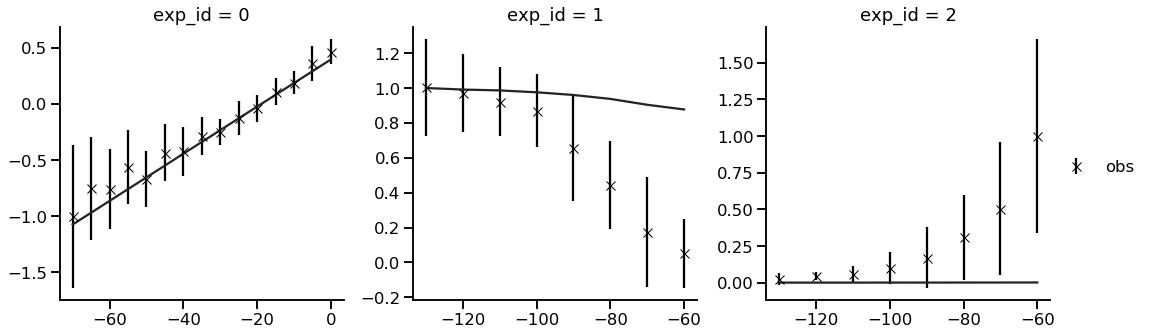

In [6]:
import pandas as pd
results = summary_statistics(model({}))
output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                       'exp_id': observations.exp_id})
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(output, obs=observations)

## Set limits and generate uniform initial priors

In [6]:
from pyabc import Distribution, RV
limits = {'iha.g_ha': (0., 0.1),
          'iha.k_haNa': (0., 1.),
          'log_iha.p_1': (-7., 3.),
          'iha.p_2': (1e-7, 0.4),
          'log_iha.p_3': (-7., 3.),
          'iha.p_4': (1e-7, 0.4)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [7]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl1_iha.db"))

In [8]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [9]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [11]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(5000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.16390301259998397, '1': 0.22902566087383505, '2': 0.2933027160116223, '3': 0.31543877005023563, '4': 0.41795637031656213, '5': 0.41795637031656213, '6': 0.47768899253833425, '7': 0.6191739814943672, '8': 0.8799498340377078, '9': 0.6966200763930558, '10': 0.8799915239905253, '11': 0.8799498340377078, '12': 1.044832148105304, '13': 0.6687061166787146, '14': 0.9287919340368063, '15': 0.7082467390919117, '16': 0.8748602520647568, '17': 0.9915928038116687, '18': 0.9297218899450758, '19': 0.6466690202816548, '20': 0.7829236967958513, '21': 0.6198145932967164, '22': 0.9915928038116687, '23': 3.9248639046834244, '24': 3.9248639046834244, '25': 3.556334853255553, '26': 1.7798355011367695, '27': 0.949245600606269, '28': 0.6780325718616244, '29': 0.4314752730028523, '30': 0.29663925018946075}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [12]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [13]:
abc_id = abc.new(db_path, obs)

In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=200, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 5178
DEBUG:Epsilon:new eps, t=1, eps=3.6472934148789946
INFO:ABC:t:1 eps:3.6472934148789946
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 15520
DEBUG:Epsilon:new eps, t=2, eps=1.9774405644814153
INFO:ABC:t:2 eps:1.9774405644814153
DEBUG:ABC:now submitting population 2


In [10]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc_continued = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(5000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.16390301259998397, '1': 0.22902566087383505, '2': 0.2933027160116223, '3': 0.31543877005023563, '4': 0.41795637031656213, '5': 0.41795637031656213, '6': 0.47768899253833425, '7': 0.6191739814943672, '8': 0.8799498340377078, '9': 0.6966200763930558, '10': 0.8799915239905253, '11': 0.8799498340377078, '12': 1.044832148105304, '13': 0.6687061166787146, '14': 0.9287919340368063, '15': 0.7082467390919117, '16': 0.8748602520647568, '17': 0.9915928038116687, '18': 0.9297218899450758, '19': 0.6466690202816548, '20': 0.7829236967958513, '21': 0.6198145932967164, '22': 0.9915928038116687, '23': 3.9248639046834244, '24': 3.9248639046834244, '25': 3.556334853255553, '26': 1.7798355011367695, '27': 0.949245600606269, '28': 0.6780325718616244, '29': 0.4314752730028523, '30': 0.29663925018946075}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [11]:
abc_continued.load(db_path, 1)

1

In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=200, min_acceptance_rate=0.005)

INFO:Epsilon:initial epsilon is 0.34775346395080825
INFO:ABC:t:123 eps:0.34775346395080825
DEBUG:ABC:now submitting population 123


# Results analysis

In [13]:
from pyabc import History

In [14]:
print(db_path)
history = History(db_path)
history.all_runs()

sqlite:////scratch/cph211/tmp/hl1_iha.db


[<ABCSMC(id=1, start_time=2019-07-22 14:18:38.382507, end_time=2019-07-25 06:08:41.454041)>]

In [15]:
history.id = 1

In [16]:
df, w = history.get_distribution(m=0)

In [17]:
df.describe()

name,iha.g_ha,iha.k_haNa,iha.p_2,iha.p_4,log_iha.p_1,log_iha.p_3
count,5.000000e+03,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000
mean,2.076865e-02,0.187503,5.038395e-02,8.008732e-02,-1.984634,-6.473939
std,7.306204e-07,0.000005,1.401761e-07,5.607030e-07,0.000003,0.000010
min,2.076626e-02,0.187486,5.038367e-02,8.008496e-02,-1.984638,-6.473956
25%,2.076815e-02,0.187499,5.038385e-02,8.008704e-02,-1.984636,-6.473947
50%,2.076866e-02,0.187503,5.038392e-02,8.008728e-02,-1.984634,-6.473938
75%,2.076918e-02,0.187506,5.038403e-02,8.008784e-02,-1.984632,-6.473933
max,2.077108e-02,0.187520,5.038478e-02,8.008824e-02,-1.984613,-6.473896


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:139: RuntimeWarning: invalid value encountered in true_divide
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


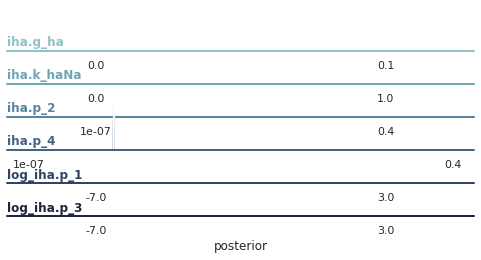

In [18]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

# Samples for quantitative analysis

In [19]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [20]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

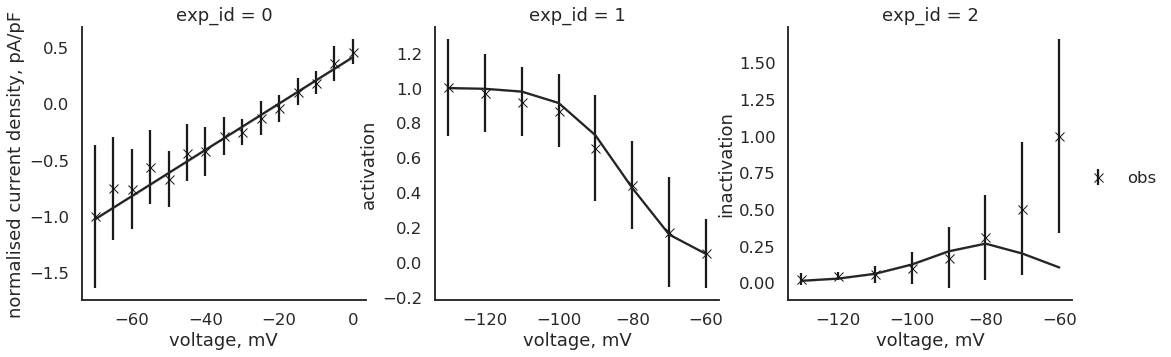

In [21]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=observations)

# Set axis labels
#xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]#, "time, ms","voltage, mV"]
#ylabels = ["normalised current density, pA/pF", "activation", "inactivation", "recovery"]#, "normalised current","current density, pA/pF"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)

In [103]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

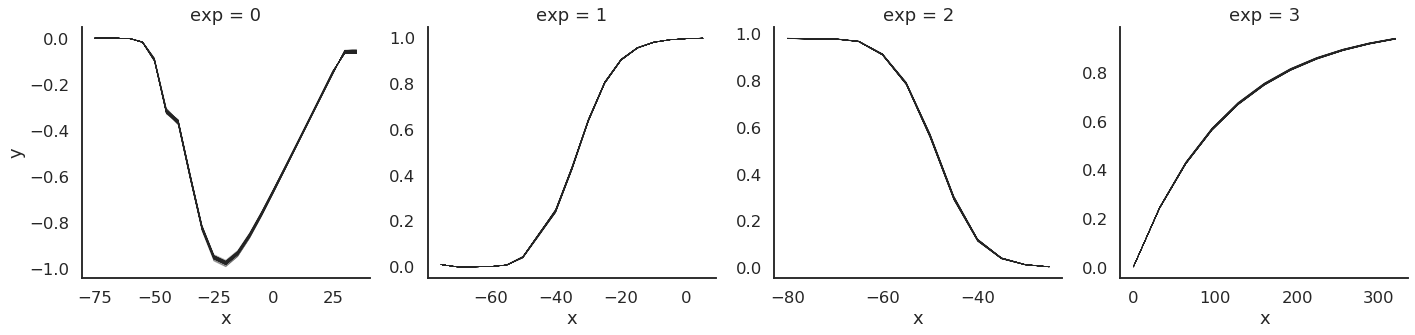

In [104]:
grid2 = plot_sim_results_all(samples)

In [33]:
#grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [35]:
import numpy as np

In [42]:
# Mean current density
print(np.mean(samples[samples.exp=='0'].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp=='0'].groupby('sample').min()['y']))

-0.9792263129382246
0.060452038127623814


In [43]:
import scipy.stats as st
peak_current = samples[samples['exp']=='0'].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [44]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -0.9929750589235674
95% CI: (-1.0714884415582595, -0.8489199437971181)


In [45]:
# Voltage of peak current density
idxs = samples[samples.exp=='0'].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -20.1
STD: 0.7


In [46]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -20.0
95% CI: (-20.0, -20.0)


In [48]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']=='1'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [49]:
print(np.mean(output))
print(np.std(output))

0   -33.399071
1     5.739255
dtype: float64
0    0.823473
1    0.366996
dtype: float64


In [50]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -33.407394098238164
95% CI: (-34.93130871417603, -31.973122716861205)


In [51]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.728938366573993
95% CI: (5.117385157850234, 6.485585591389819)


In [52]:
# Half activation potential
grouped = samples[samples['exp']=='2'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [53]:
print(np.mean(output))
print(np.std(output))

0   -49.011222
1     4.399126
dtype: float64
0    0.613833
1    0.306758
dtype: float64


In [54]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -49.01404281457659
95% CI: (-50.06478757419054, -47.57952101705519)


In [55]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 4.420440009120772
95% CI: (3.7821747606540193, 4.959106709731536)


In [56]:
# Recovery time constant
grouped = samples[samples.exp=='3'].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [57]:
print(np.mean(output))
print(np.std(output))

114.50830523453935
5.781251582667316


In [58]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 113.75533911706513
95% CI: (104.11137902797657, 125.98102619971708)
